In [49]:
# $ conda install -c anaconda py-xgboost
# (리눅스) conda install -c conda-forge xgboost

In [50]:
# xgboost 모듈 임포트
import xgboost as xgb
from xgboost import XGBClassifier

In [51]:
# 버전 확인
import xgboost
print(xgboost.__version__)

0.90


###  위스콘신 유방암 예측

### 1. 파이썬 래퍼 XGBoost 적용

In [52]:
# XGBoost의 파이썬 패키지인 xgboost는
# 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화 기능을 가지고 있다
# 또한 조기 중단 기능이 있어서
# num_rounds로 지정한 부스팅 반복 횟수에 도달하지 않더라도
# 더 이상 예측 오류가 개선되지 않으면 반복을 끝까지 수행하지 않고 중지해
# 수행 시간을 개선하는 기능도 가지고 있다

In [53]:
# 위스콘신 유방암 데이터 세트
# - 종양의 크기, 모양 등의 다양한 속성값 기반

# malignant : 악성 종양
# benign : 양성 종양

In [54]:
import xgboost as xgb
# plot_importance : 피처의 중요도 시각화해주는 모듈
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

In [55]:
dataset.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [56]:
X_features = dataset.data
y_label = dataset.target

In [57]:
cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [58]:
# malignant(0) : 악성 종양
# benign(1) : 양성 종양
cancer_df['target'] = y_label

In [59]:
cancer_df.head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0


In [60]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [61]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                   test_size = 0.2, random_state = 156)

In [62]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [63]:
# 학습용과 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix를 생성
# DMatrix : 주로 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [64]:
# XGBoost의 하이퍼 파라미터 설정
# 주로 딕셔너리 형태로 입력
params = {
    'max_depth' : 3,
    'eta' : 0.1,
    'objective' : 'binary:logistic',
    'eval_metric' : 'logloss',
    'early_stoppings' : 100
}
num_rounds = 400

In [65]:
# train 데이터 세트는 'train'
# evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
# 학습이 완료된 모델 객체 반환
xgb_model = xgb.train(params = params, dtrain = dtrain, 
                      num_boost_round = num_rounds, evals = wlist)

[0]	train-logloss:0.609685	eval-logloss:0.61352
[1]	train-logloss:0.540804	eval-logloss:0.547842
[2]	train-logloss:0.483755	eval-logloss:0.494247
[3]	train-logloss:0.434455	eval-logloss:0.447986
[4]	train-logloss:0.390549	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292592	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245152	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192183	eval-logloss:0.231556
[13]	train-logloss:0.177917	eval-logloss:0.22005
[14]	train-logloss:0.165221	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logloss:0.133985	eval-logloss:0.181818
[18]	train-logloss:0.125599	eval-logloss:0.174729
[19]	train-logloss:0.117286	eval-logloss:0.167657
[20]	train-log

[164]	train-logloss:0.0072	eval-logloss:0.087777
[165]	train-logloss:0.00718	eval-logloss:0.087517
[166]	train-logloss:0.007161	eval-logloss:0.087542
[167]	train-logloss:0.007142	eval-logloss:0.087642
[168]	train-logloss:0.007122	eval-logloss:0.08739
[169]	train-logloss:0.007103	eval-logloss:0.087377
[170]	train-logloss:0.007084	eval-logloss:0.087298
[171]	train-logloss:0.007065	eval-logloss:0.087368
[172]	train-logloss:0.007047	eval-logloss:0.087395
[173]	train-logloss:0.007028	eval-logloss:0.087385
[174]	train-logloss:0.007009	eval-logloss:0.087132
[175]	train-logloss:0.006991	eval-logloss:0.087159
[176]	train-logloss:0.006973	eval-logloss:0.086955
[177]	train-logloss:0.006955	eval-logloss:0.087053
[178]	train-logloss:0.006937	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.086973
[180]	train-logloss:0.006901	eval-logloss:0.087038
[181]	train-logloss:0.006884	eval-logloss:0.086799
[182]	train-logloss:0.006866	eval-logloss:0.086826
[183]	train-logloss:0.006849	eval-log

[326]	train-logloss:0.005354	eval-logloss:0.08578
[327]	train-logloss:0.005348	eval-logloss:0.085857
[328]	train-logloss:0.005342	eval-logloss:0.085939
[329]	train-logloss:0.005336	eval-logloss:0.085825
[330]	train-logloss:0.00533	eval-logloss:0.085869
[331]	train-logloss:0.005324	eval-logloss:0.085893
[332]	train-logloss:0.005318	eval-logloss:0.085922
[333]	train-logloss:0.005312	eval-logloss:0.085842
[334]	train-logloss:0.005306	eval-logloss:0.085735
[335]	train-logloss:0.0053	eval-logloss:0.085816
[336]	train-logloss:0.005294	eval-logloss:0.085892
[337]	train-logloss:0.005288	eval-logloss:0.085936
[338]	train-logloss:0.005283	eval-logloss:0.08583
[339]	train-logloss:0.005277	eval-logloss:0.085909
[340]	train-logloss:0.005271	eval-logloss:0.085831
[341]	train-logloss:0.005265	eval-logloss:0.085727
[342]	train-logloss:0.00526	eval-logloss:0.085678
[343]	train-logloss:0.005254	eval-logloss:0.085721
[344]	train-logloss:0.005249	eval-logloss:0.085796
[345]	train-logloss:0.005243	eval-log

In [66]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]


In [67]:
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정해
# 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시 : ', preds[:10])

예측값 10개만 표시 :  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, auc))

In [69]:
# XGBoost 모델의 예측 성능 평가
get_clf_eval(y_test, preds)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.9737, 정밀도 : 0.9744, 재현율 : 0.9870, F1 : 0.9806, AUC : 0.9665


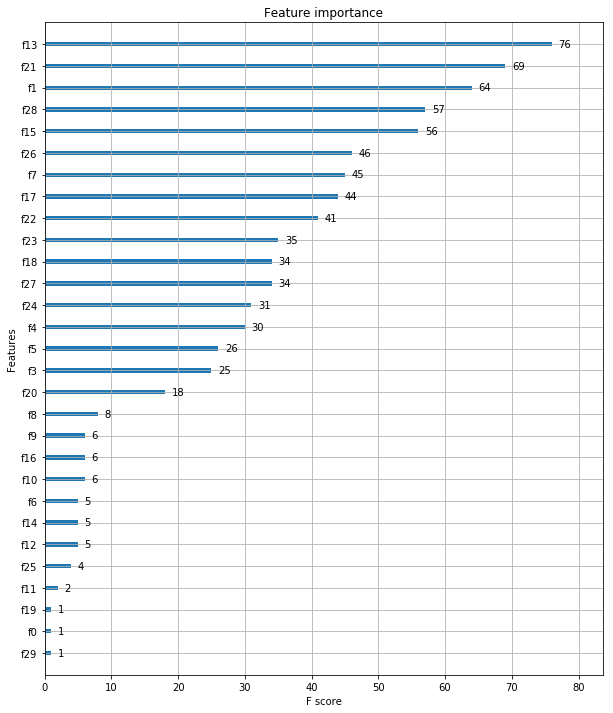

In [70]:
# plot_importance() : 피처의 중요도를 막대그래프 형식으로 나타낸다
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb_model, ax = ax)

### 2. 사이킷런 래퍼 XGBoost 적용

In [71]:
# 사이킷런의 프레임워크와 연동하기 위해 사이킷런 전용 XGBoost 래퍼 클래스 개발
# 사이킷런의 기본 Estimator를 그대로 상속
# → 다른 Estimator와 동일하게 fit(), predict()만으로 학습/예측 가능
# GridSearchCV, Pipeline 등 사이킷런의 다른 유틸리티를 그대로 사용 가능

In [72]:
# 사이킷런을 위한 래퍼 XGBoost
# - 분류를 위한 래퍼 클래스 : XGBClassifier
# - 회귀를 위한 래퍼 클래스 : XGBRegressor 

In [79]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                   test_size = 0.2, random_state = 156)

In [80]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)

In [81]:
get_clf_eval(y_test, w_preds)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.9737, 정밀도 : 0.9744, 재현율 : 0.9870, F1 : 0.9806, AUC : 0.9665


In [82]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
evals = [(X_test, y_test)]
xgb_wrapper.fit( X_train, y_train, early_stopping_rounds = 100, 
                eval_metric = 'logloss', eval_set = evals, verbose = True )
ws100_preds = xgb_wrapper.predict( X_test )

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[230]	validation_0-logloss:0.086002
[231]	validation_0-logloss:0.085922
[232]	validation_0-logloss:0.086102
[233]	validation_0-logloss:0.086115
[234]	validation_0-logloss:0.086169
[235]	validation_0-logloss:0.086263
[236]	validation_0-logloss:0.086292
[237]	validation_0-logloss:0.086217
[238]	validation_0-logloss:0.086395
[239]	validation_0-logloss:0.086342
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.086195
[242]	validation_0-logloss:0.086248
[243]	validation_0-logloss:0.086263
[244]	validation_0-logloss:0.086293
[245]	validation_0-logloss:0.086222
[246]	validation_0-logloss:0.086398
[247]	validation_0-logloss:0.086347
[248]	validation_0-logloss:0.086276
[249]	validation_0-logloss:0.086448
[250]	validation_0-logloss:0.086294
[251]	validation_0-logloss:0.086312
[252]	validation_0-logloss:0.086364
[253]	validation_0-logloss:0.086394
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.086441
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08

In [83]:
get_clf_eval(y_test, ws100_preds)

오차 행렬
[[34  3]
 [ 1 76]]
정확도 : 0.9649, 정밀도 : 0.9620, 재현율 : 0.9870, F1 : 0.9744, AUC : 0.9530


In [84]:
# early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit( X_train, y_train, early_stopping_rounds = 10, 
                eval_metric = 'logloss', eval_set = evals, verbose = True )
ws10_preds = xgb_wrapper.predict(X_test)
get_clf_eval(y_test, ws10_preds)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


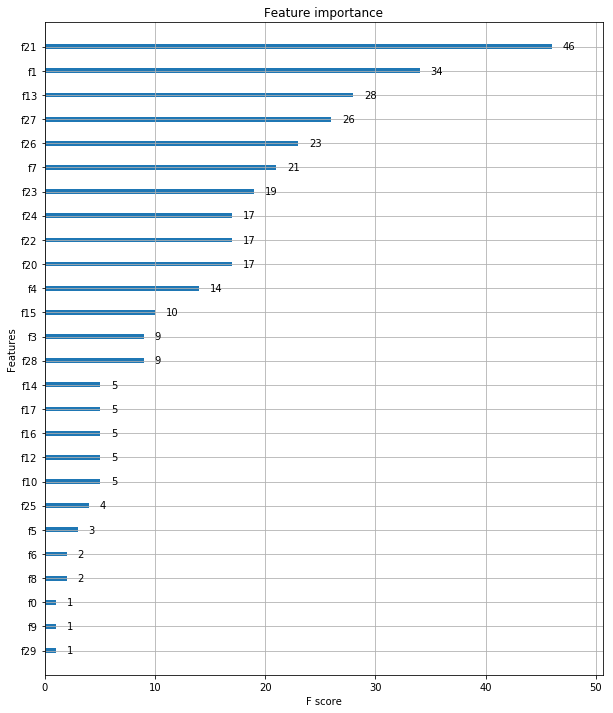

In [85]:
# 피처 중요도 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax = ax)